# Face Mask Detection Using YOLOv3
*Francisco de Abreu e Lima - 14 June, 2021*

In this notebook we will fine-tune a pre-trained YOLOv3 model to identify bare faces and mask-wearing faces. To this end we must

- Clone the DarkNet GitHub repository, compile
- Download dataset, test media (images and videos) and the YOLOv3 convolutional backbone
- Partition train and test data, edit existing `class.names`, `.cfg` and `.data` files
- Train network, run inference on test media and display prediction example


## 1. Download and compile DarkNet

Firstly we need to clone the DarkNet GitHub repository, then compile `darknet` with the `OPENCV`, `GPU` and `CUDA` options, as shown below.

In [1]:
-# Clone Darknet GitHub repo
!git clone https://github.com/AlexeyAB/darknet.git

# cd and compile w/ OpenCV and GPU options enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print('Building... This can take two minutes')
!make &> build_log.txt

Cloning into 'darknet'...
remote: Enumerating objects: 15097, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 15097 (delta 8), reused 9 (delta 2), pack-reused 15072
Receiving objects: 100% (15097/15097), 13.49 MiB | 20.80 MiB/s, done.
Resolving deltas: 100% (10253/10253), done.
/content/darknet
Building... This can take two minutes


## 2. Download YOLOv3 conv backbone, dataset and test media

To bring our model to its fullest potential, we will leverage transfer learning by borrowing the convolutional backbone trained using ImageNet. We will download the corresponding structure and weights, as well as the provided annotated mask / no-mask dataset - output format already conforms to YOLO - and test images and videos to predict on, after training.

In [2]:
%%bash
# Download conv backbone from YOLOv3, dataset and test imgs/vids (silent mode)
wget "https://pjreddie.com/media/files/darknet53.conv.74" -q -O darknet53.conv.74
wget "https://www.dropbox.com/s/uq0x32w70c390fb/mask_no-mask_dataset.zip?dl=1" -q -O dataset.zip
unzip -qq dataset.zip -d dataset && rm dataset.zip
wget "https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1" -q -O test-image1.jpg
wget "https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1" -q -O test-image2.jpg
wget "https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1" -q -O test-image3.jpg
wget "https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1" -q -O test-image4.jpg
wget "https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1" -q -O test-video1.mp4
wget "https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1" -q -O test-video2.mp4

## 3. Partition train and test data

Here we will use code from the course to partition the dataset into train and test sets. Note that the partition is not seeded, and each time it provides different splits.

In [3]:
# Prepare dataset
import random
import os
import subprocess
import sys

image_dir = "./dataset"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

## 4. Set up train and test configuration

Next we need to modify `yolov3.cfg` to accommodate the two classes, `Face mask` and `Bare face`. Then, we make the necessary changes to `cfg/yolov3.cfg` to fine-tune our model. We leave momentum, decay, learning rate and policy with the default values, *i.e.* 0.9, 0.0005, 0.001 and `steps`, respectively. Likewise, we will leave the augmentation defaults.


In [4]:
%%bash
# Setup class.names
echo "Face mask" > class.names
echo "Bare face" >> class.names

# Setup yolov3-fmask.data
echo "classes = 2" > yolov3-fmask.data
echo "train = data_train.txt" >> yolov3-fmask.data
echo "valid = data_test.txt" >> yolov3-fmask.data
echo "names = class.names" >> yolov3-fmask.data
echo "backup = backup/" >> yolov3-fmask.data

# Modify config file (test)
sed -i 's/filters=255/filters=21/' cfg/yolov3.cfg
sed -i 's/classes=80/classes=2/' cfg/yolov3.cfg
sed -i 's/max_batches =.*/max_batches=1000/' cfg/yolov3.cfg
sed -i 's/steps=.*$/steps=800/' cfg/yolov3.cfg
sed -i 's/scales=.*$/scales=.1/' cfg/yolov3.cfg
sed -i 's/burn_in=.*$/burn_in=100/' cfg/yolov3.cfg

# Rename to yolov3_test
mv cfg/yolov3.cfg cfg/yolov3_test.cfg

Note that the configuration file is by default used for test. For this reason we will make a copy for training, `cfg/yolov3_train.cfg`.

In [5]:
%%bash
# Modify config file (train)
cp cfg/yolov3_test.cfg cfg/yolov3_train.cfg
sed -i 's/batch=1/# batch=1/' cfg/yolov3_train.cfg
sed -i 's/subdivisions=1$/# subdivisions=1/' cfg/yolov3_train.cfg
sed -i 's/# batch=64/batch=64/' cfg/yolov3_train.cfg
sed -i 's/# subdivisions=16/subdivisions=16/' cfg/yolov3_train.cfg

## 5. Start training

We are now ready to start the training routine. This might take a while. **Note that Google Colab might restrict your GPU usage. Avoid unnecessary, long computations.**

In [6]:
# Run training routine
!./darknet detector train yolov3-fmask.data cfg/yolov3_train.cfg darknet53.conv.74 -dont_show -map 2> train_log.txt

Streaming output truncated to the last 5000 lines.
 131: 5.247258, 4.074699 avg loss, 0.001000 rate, 4.685341 seconds, 8384 images, 1.796625 hours left
Loaded: 0.000049 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 1.08 %, best = 1.08 % 
 132: 4.152720, 4.082501 avg loss, 0.001000 rate, 4.766704 seconds, 8448 images, 1.790178 hours left
Loaded: 0.000042 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 1.08 %, best = 1.08 % 
 133: 3.831043, 4.057355 avg loss, 0.001000 rate, 4.769759 seconds, 8512 images, 1.783769 hours left
Loaded: 0.000044 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 1.08 %, best = 1.08 % 
 134: 2.682415, 3.919861 avg loss, 0.001000 rate, 4.732761 seconds, 8576 images, 1.777419 hours left
Loaded: 0.000042 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 1.08 %, best = 1.08 % 
 135: 3.819545, 3.909830 avg loss, 0.001000 rate, 4.763200 seconds, 8640 imag

The reported final mean average precision (mAP) with a IoU threshold of 50% should be ~70%.

## 6. Inference on test images and videos

To conclude, we will faces with and without mask on test images and videos.


In [13]:
# On images
!./darknet detector test yolov3-fmask.data cfg/yolov3_test.cfg backup/yolov3_train_best.weights test-image1.jpg -thresh .6 2> /dev/null
!mv predictions.jpg yolov3_test-image1_pred.jpg 

!./darknet detector test yolov3-fmask.data cfg/yolov3_test.cfg backup/yolov3_train_best.weights test-image2.jpg -thresh .6 2> /dev/null
!mv predictions.jpg yolov3_test-image2_pred.jpg 

!./darknet detector test yolov3-fmask.data cfg/yolov3_test.cfg backup/yolov3_train_best.weights test-image3.jpg -thresh .6 2> /dev/null
!mv predictions.jpg yolov3_test-image3_pred.jpg

!./darknet detector test yolov3-fmask.data cfg/yolov3_test.cfg backup/yolov3_train_best.weights test-image4.jpg -thresh .6 2> /dev/null
!mv predictions.jpg yolov3_test-image4_pred.jpg 

# On videos
!./darknet detector demo yolov3-fmask.data cfg/yolov3_test.cfg backup/yolov3_train_best.weights test-video1.mp4 -thresh .6 -out_filename yolov3_test-video1_pred.mp4 -dont_show
!./darknet detector demo yolov3-fmask.data cfg/yolov3_test.cfg backup/yolov3_train_best.weights test-video2.mp4 -thresh .6 -out_filename yolov3_test-video2_pred.mp4 -dont_show

Streaming output truncated to the last 5000 lines.

 cvWriteFrame 
Objects:

Bare face: 72% 

FPS:34.8 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 65% 

FPS:34.1 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 84% 
Bare face: 64% 

FPS:33.8 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 71% 
Bare face: 63% 
Bare face: 61% 

FPS:32.7 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 73% 
Bare face: 64% 

FPS:32.7 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 77% 
Bare face: 64% 

FPS:32.0 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 71% 

FPS:33.1 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 79% 
Bare face: 68% 

FPS:34.0 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 80% 
Bare face: 77% 
Bare face: 60% 

FPS:34.1 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 75% 
Bare face: 74% 
Bare face: 70% 

FPS:33.5 	 AVG_FPS:33.5

 cvWriteFrame 
Objects:

Bare face: 74% 
Bare face: 73% 
Bare face: 68% 

FPS:33.7 	 AVG_FPS:33.5

 cvWriteFrame 
Obje

Finally, let us display the first test image in the list after predictions.

(-0.5, 1119.5, 1637.5, -0.5)

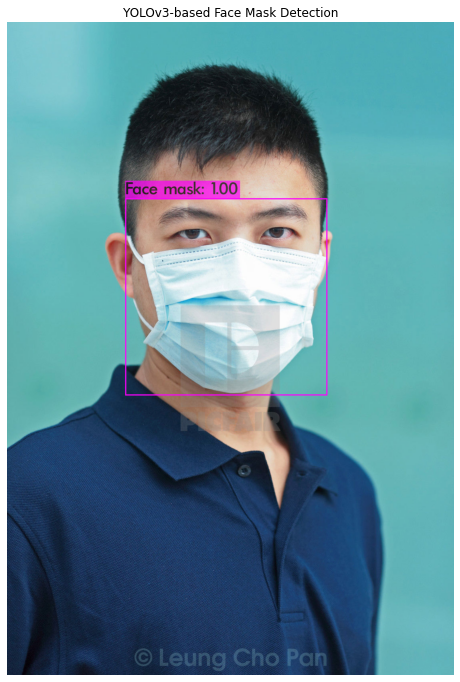

In [15]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('yolov3_test-image1_pred.jpg')
plt.figure(figsize=(12, 12))
plt.imshow(im[...,::-1]); plt.title('YOLOv3-based Face Mask Detection'); plt.axis('off')

That is it - well done for training YOLOv3 for a custom classification task!